## Importamos librerias necesarias para iniciar EDA

In [56]:
import pandas as pd
import numpy as np
import warnings
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
from IPython.display import display
# Text
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


warnings.filterwarnings('ignore')#to filter all the warnings
pd.set_option('float_format', '{:.4f}'.format)# to keep the float values short

[nltk_data] Downloading package punkt to /home/kennydev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kennydev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Carga del dataset preprocesado

In [57]:
df = pd.read_csv('../data/preprocessed/video_cln.csv')
df['trending_date'] = pd.to_datetime(df['trending_date'])
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['category_name']= df['category_name'].astype('category')
df.drop_duplicates()
df.head(3)

video_id trending_date  category_id        publish_time    views  \
0  2kyS6SvSYSE    2017-11-14           22 2017-11-13 17:13:01   748374   
1  1ZAPwfrtAFY    2017-11-14           24 2017-11-13 07:30:00  2418783   
2  5qpjK5DgCt4    2017-11-14           23 2017-11-12 19:05:24  3191434   

    likes  dislikes  comment_count   category_name  \
0   57527      2966          15954  People & Blogs   
1   97185      6146          12703   Entertainment   
2  146033      5339           8181          Comedy   

                                                tags  \
0                                    shantell martin   
1  last week tonight trump presidency last week t...   
2  racist superman rudy mancuso king bach racist ...   

                                         video_title    channel_title  \
0                 we want to talk about our marriage     caseyneistat   
1  the trump presidency last week tonight with jo...  lastweektonight   
2   racist superman rudy mancuso king bach lele pons     rudy mancuso   

                                         description  
0  shantell s channel https www youtube com shant...  
1  one year after the presidential election john ...  
2  watch my previous video n nsubscribe https www...

### Descripcion del dataset preprocesado

* video_id------------------------- ID de cada video `(string)`
* published_time----------------------- Fecha _(año-mes-dia)_ de publicacion del video `(datetime)`
* category_id------------------------ Id de cada categoria por video `(Int)`
* trending_date---------------------- Fecha _(año-mes-dia hora:min:seg)_ en el que el video se hizo viral `(datetime)`
* view_count------------------------- Cantidad de visitas del video `(Int)`
* likes------------------------------ Cantidad del likes del video `(Int)`
* dislikes--------------------------- Cantidad de dislike del video `(Int)`
* comment_count---------------------- Cantidad de comentarios del video `(Int)`
* category_name----------------------- Nombre de la categoria ligada al category_id `(category)`
* description----------------------------- Descripcion por cada video `(string)`
* tags--------------------------------------- Etiquetas sobre el contenido del video `(string)`
* video_title------------------------------ Titulo del video `(string)`
* channel_title-------------------------- Titulo del canal que publico el video `(string)`

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   video_id       40949 non-null  object        
 1   trending_date  40949 non-null  datetime64[ns]
 2   category_id    40949 non-null  int64         
 3   publish_time   40949 non-null  datetime64[ns]
 4   views          40949 non-null  int64         
 5   likes          40949 non-null  int64         
 6   dislikes       40949 non-null  int64         
 7   comment_count  40949 non-null  int64         
 8   category_name  40949 non-null  category      
 9   tags           40949 non-null  object        
 10  video_title    40946 non-null  object        
 11  channel_title  40949 non-null  object        
 12  description    40949 non-null  object        
dtypes: category(1), datetime64[ns](2), int64(5), object(5)
memory usage: 3.8+ MB


### 1. ¿Cuáles son las categorías de vídeos que reciben mayores vistas y Likes?

In [59]:
df[df['description'].isna()]

Empty DataFrame
Columns: [video_id, trending_date, category_id, publish_time, views, likes, dislikes, comment_count, category_name, tags, video_title, channel_title, description]
Index: []

In [60]:
# ¿Cuantas categorias existen en nuestro dataset?
len(df['category_name'].unique())

16

In [61]:
df_like_dislikes_cat = df.drop_duplicates(subset=['video_id'], keep='last')

In [90]:
df_like_dislikes_cat = df_like_dislikes_cat.groupby('category_name')[['likes', 'dislikes', 'views']].sum()
df_like_dislikes_cat.sort_values('views', ascending=False, inplace=True)

In [92]:
fig = px.line(df_like_dislikes_cat, 
              x=df_like_dislikes_cat.index,
              y='views',
              title='Views per category')
fig.show()

<p style='color: green'>Conclusion</p>

* `Music` es la categoria que mas vistas acumula con mas de 5 billones de visitas
* `Entertainment` es la categoria que se acerca mas a music pero esta cuenta con un total de 2.8B de visitas acumuladas.
* `Film & Animation` obtiene el 3er lugar de esta ranking con mas de 814M de visitas acumuladas en sus videos

In [94]:
df_like_dislikes_cat.sort_values('likes', ascending=False, inplace=True)

In [95]:
plt.rcParams["figure.figsize"] = (12,8)
fig = px.line(df_like_dislikes_cat, 
              x=df_like_dislikes_cat.index,
              y='likes',
              title='Likes per category')
fig.show()

<p style='color: green'>Conclusion</p>

* `Music` es la categoria que mas likes acumula con mas de 150 millones de likes
* `Entertainment` es la categoria que se acerca mas a music pero esta cuenta con mas de 67 millones de likes acumulados.
* `Comedy` obtiene el 3er lugar de esta ranking con mas de 29 millones de likes acumulados en sus videos

### 2. ¿Es posible encontrar agrupaciones o clasificaciones de videos?

In [67]:
df.sample(3)

video_id trending_date  category_id        publish_time    views  \
13249  MvFcY9rTPx8    2018-01-21           25 2018-01-17 01:35:40  5382591   
20850  d3PMBPw74cc    2018-02-28           24 2018-02-23 16:13:43   669493   
12724  Pxf8Bf1V0is    2018-01-18           24 2018-01-14 16:42:38   110776   

       likes  dislikes  comment_count    category_name  \
13249  42599      3464              0  News & Politics   
20850   4330      1345           1784    Entertainment   
12724   8184        73            629    Entertainment   

                                                    tags  \
13249                                    michigan meteor   
20850  tamar braxton the view hot topics relationship...   
12724           movies japan japanese translations films   

                                             video_title    channel_title  \
13249                        michigan meteor jan 16 2018      mike austin   
20850  tamar braxton clears up rumors about her marri...         the view   
12724        21 strangest movie translations in japanese  abroad in japan   

                                             description  
13249  camera used http amzn to 2mhgt3y ninvest here ...  
20850  braxton and vince herbert set the record strai...  
12724  western movies adapted for japanese audiences ...

In [98]:
df['publish_month'] = df['publish_time'].dt.month_name()
df['publish_year'] = df['publish_time'].dt.year

In [99]:
categories = df['category_name'].unique()
def plot_per_category(categories, df):
    for category in categories:
        df.drop_duplicates(subset=['video_id'], keep='last', inplace = True)
        print(category)
        df1 = df[df['category_name'] == category]
        df1 = df1.groupby('publish_month')[['views', 'likes', 'dislikes']].sum()
        best_month = df1['views'].idxmax()
        print("Best month for plublish {} video is {}".format(category, best_month))
        fig = px.line(df1, x=df1.index, y='views', title=category)
        fig.show()

In [100]:
plot_per_category(categories, df)

Sports
Best month for plublish Sports video is March


Film & Animation
Best month for plublish Film & Animation video is May


News & Politics
Best month for plublish News & Politics video is May


Entertainment
Best month for plublish Entertainment video is December


Science & Technology
Best month for plublish Science & Technology video is February


Comedy
Best month for plublish Comedy video is December


Music
Best month for plublish Music video is May


Howto & Style
Best month for plublish Howto & Style video is December


People & Blogs
Best month for plublish People & Blogs video is February


Education
Best month for plublish Education video is March


Autos & Vehicles
Best month for plublish Autos & Vehicles video is February


Pets & Animals
Best month for plublish Pets & Animals video is January


Gaming
Best month for plublish Gaming video is June


Travel & Events
Best month for plublish Travel & Events video is February


Nonprofits & Activism
Best month for plublish Nonprofits & Activism video is January


Shows
Best month for plublish Shows video is April


De las graficas anteriores, separadas por categorias, encontramos que:
* No existe una formula secreta para conocer la repercusion de la fecha en el video que publiquemos
* Sin embargo, es posible notar como algunas categorias ven potenciadas su numero de visualizaciones dependiendo la epoca del año, por ejemplo:
    * `Diciembre`: Decoracion para el hogar o estilos y nuevas tendencias de moda, igualmente para la industria del entretenimiento
    * `January`: Para todo lo relacionado con educacion y el regreso a las escuelas
    *  `June`: Para la industria del gaming al igual que del cine

### 3. ¿Cuál es la combinación de características o atributos más importantes que hacen de un video tendencia?

In [71]:
stopwords = set(STOPWORDS)
stopwords.update(['follow', 'twitter', 'social', 'instagram', 'subscribe', 'snapchat', 'youtube', 'videos', 'video'\
                  ,'channel', 'share', 'facebook', 'comment', 'like', 'take', 'go', 'got', 'back',\
                  'much', 'made', 'keep', 'watch','none', 'check', 'will', 'make', 'https',\
                  'nfollow', 'ntwitter', 'nsocial', 'ninstagram', 'nhttp', 'nfacebook',\
                  'n', 'nhttps', 'tumblr', 'e', 'youtube', 'netflix', 'bit', 'ly',\
                  'nwatch', 'goo', 'gl', 'amzn', 'nnbc', 'nbc', 'youtu', 'nlike',\
                  'google', 'plus', 'nclick', 'nbctv', 'c', 's', 'nsubscribe', 'iphone',\
                  'pl7u4lwxq3wfi_7pgx0c-vtiwleu0s4v34', '2018', 'nlearn'])

def generate_wordcloud(text, stop_words):
    wordcloud = WordCloud(stopwords=stop_words,max_font_size=50, max_words=150, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
        10 palabras más frecuentes en People & Blogs para los 50 videos mas vistos
        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    


'People & Blogs'

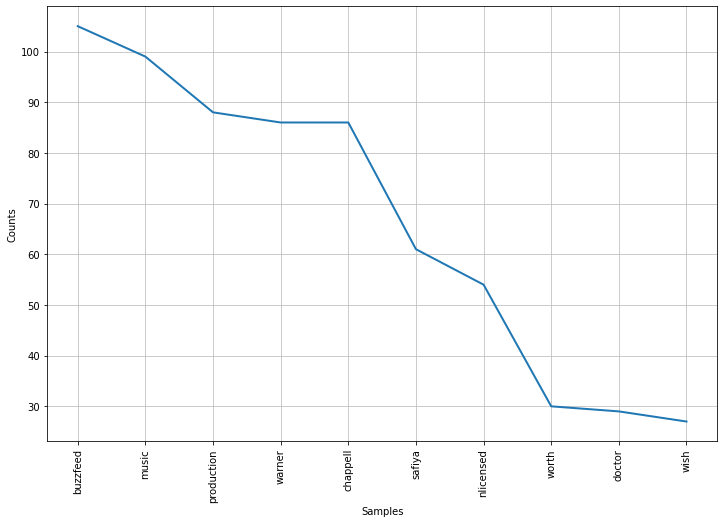

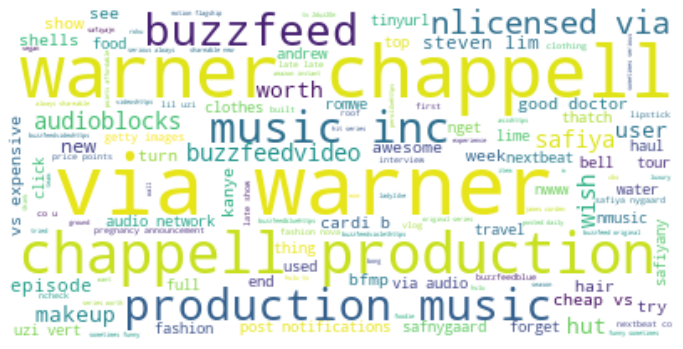


        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
        10 palabras más frecuentes en Entertainment para los 50 videos mas vistos
        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    


'Entertainment'

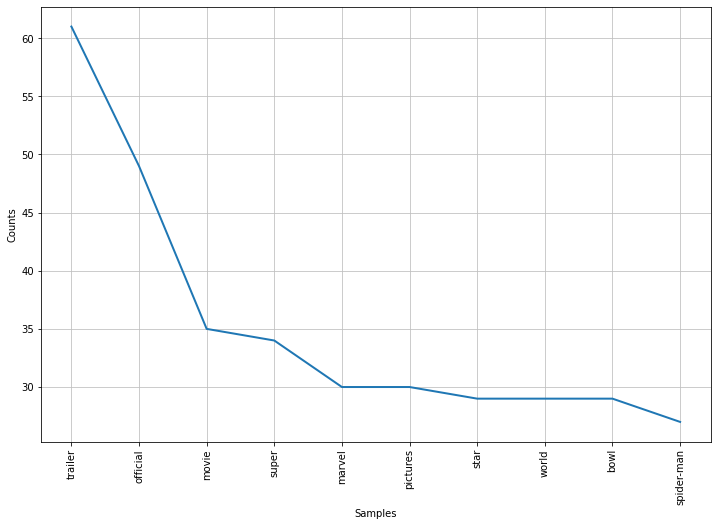

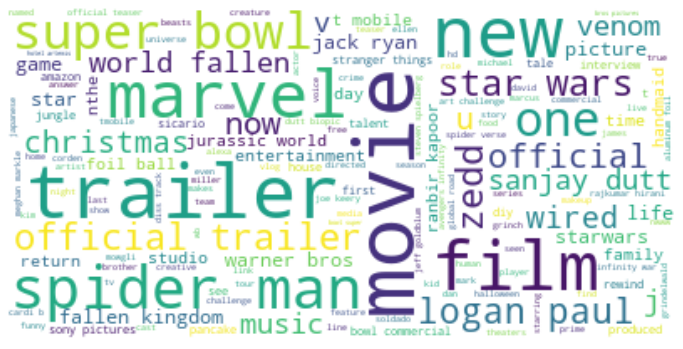


        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
        10 palabras más frecuentes en Comedy para los 50 videos mas vistos
        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    


'Comedy'

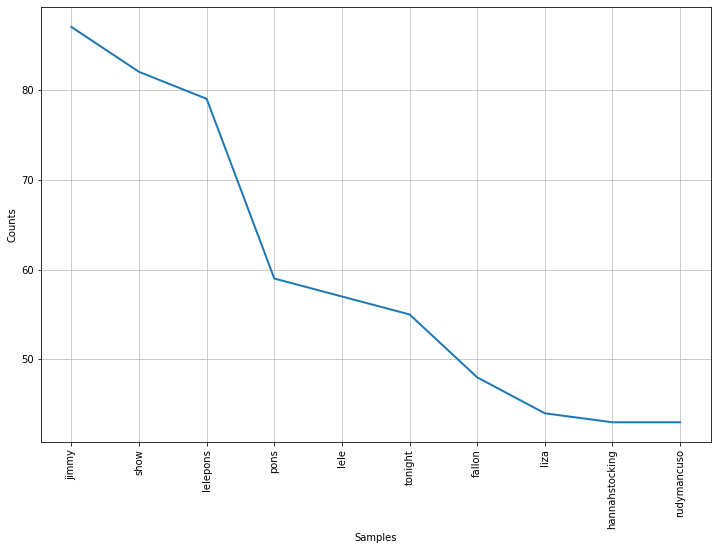

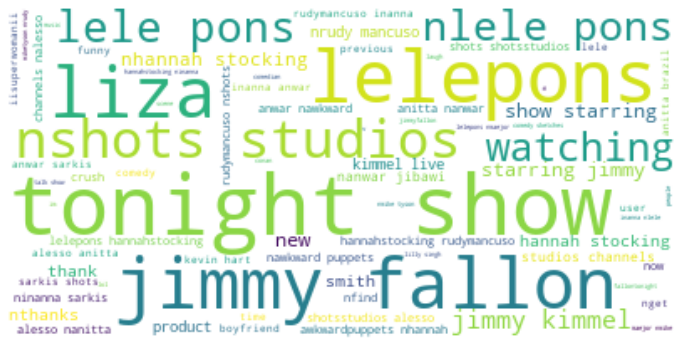


        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
        10 palabras más frecuentes en Science & Technology para los 50 videos mas vistos
        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    


'Science & Technology'

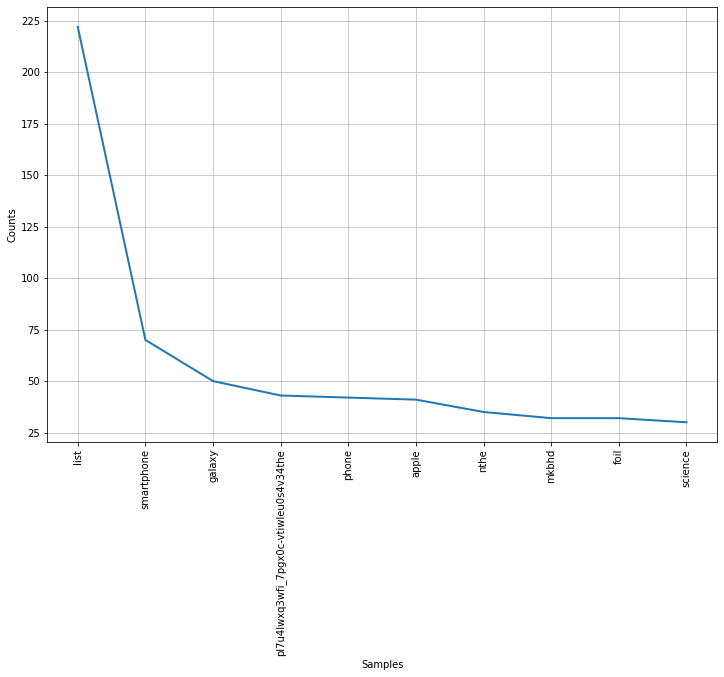

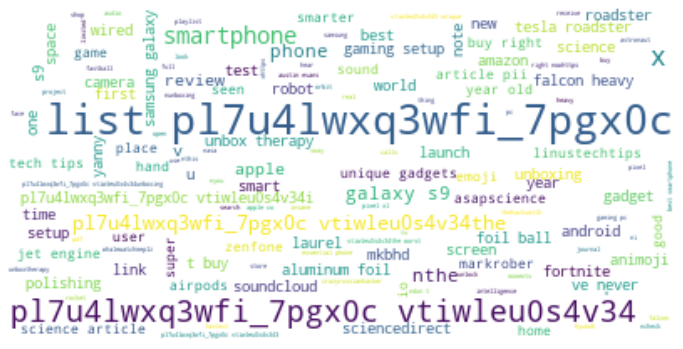


        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
        10 palabras más frecuentes en Film & Animation para los 50 videos mas vistos
        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    


'Film & Animation'

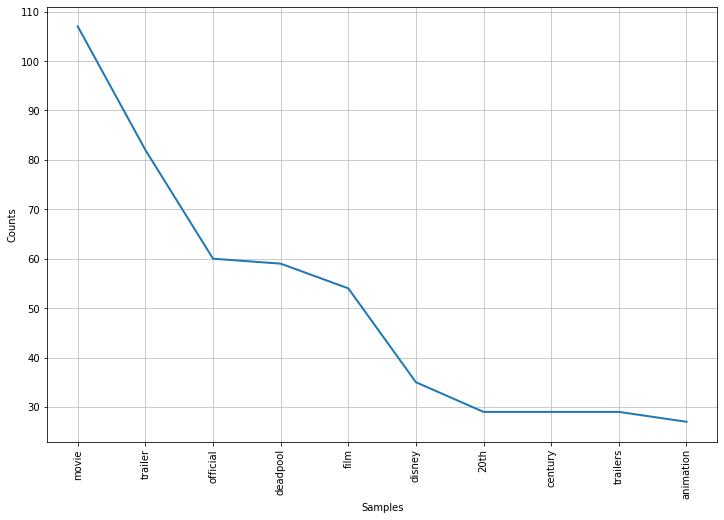

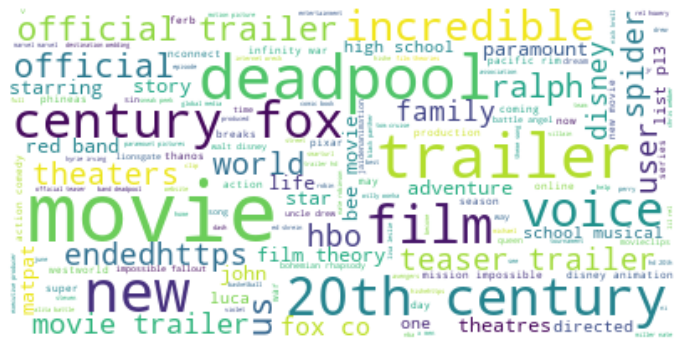


        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
        10 palabras más frecuentes en News & Politics para los 50 videos mas vistos
        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    


'News & Politics'

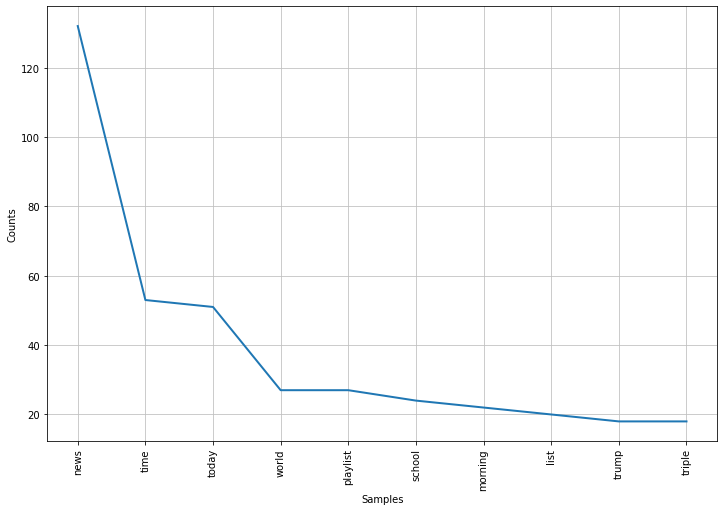

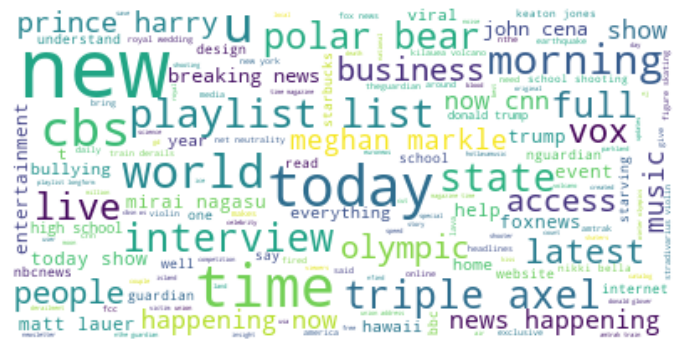


        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
        10 palabras más frecuentes en Sports para los 50 videos mas vistos
        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    


'Sports'

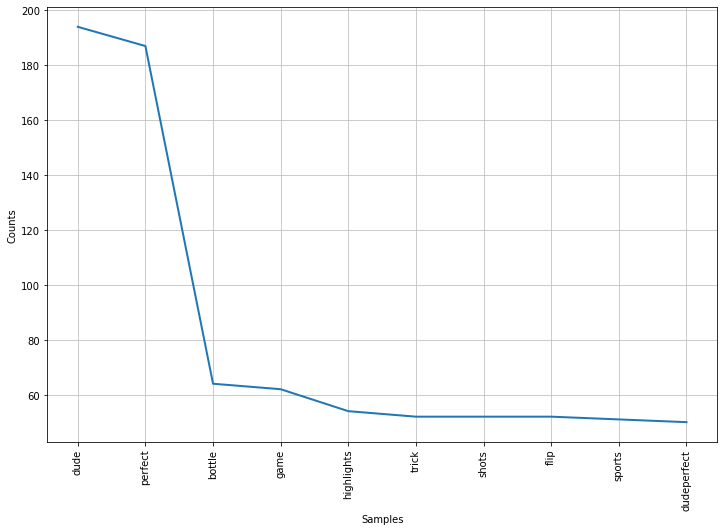

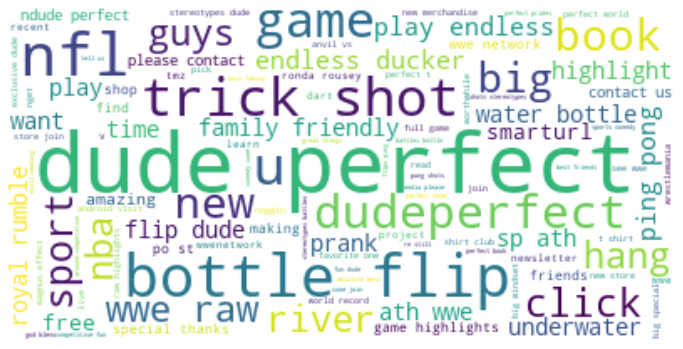


        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
        10 palabras más frecuentes en Music para los 50 videos mas vistos
        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    


'Music'

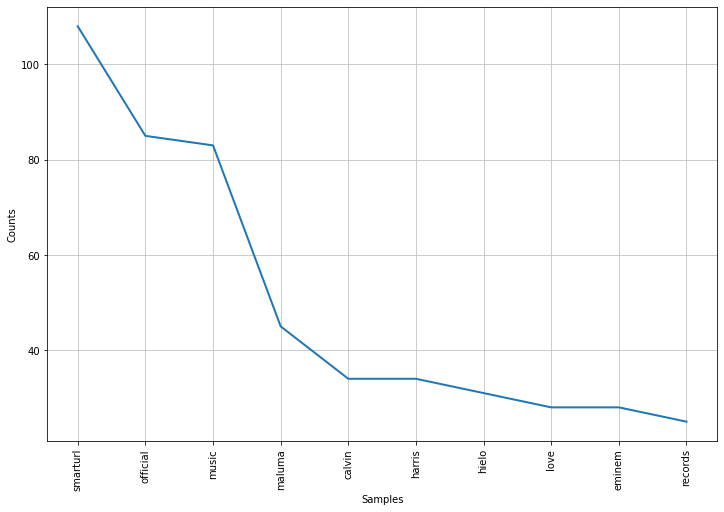

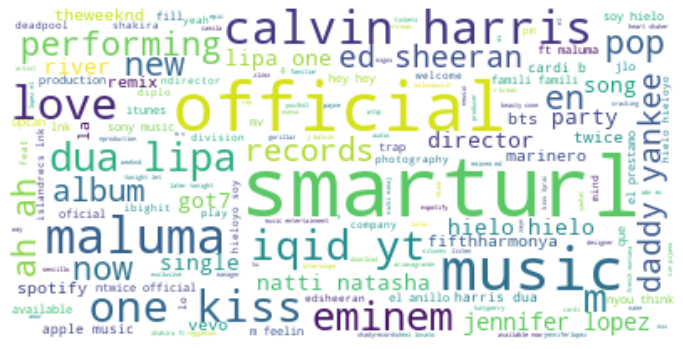


        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
        10 palabras más frecuentes en Pets & Animals para los 50 videos mas vistos
        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    


'Pets & Animals'

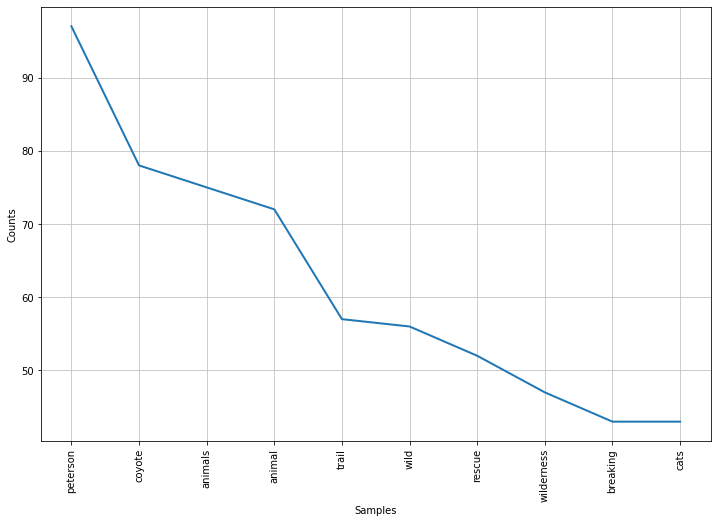

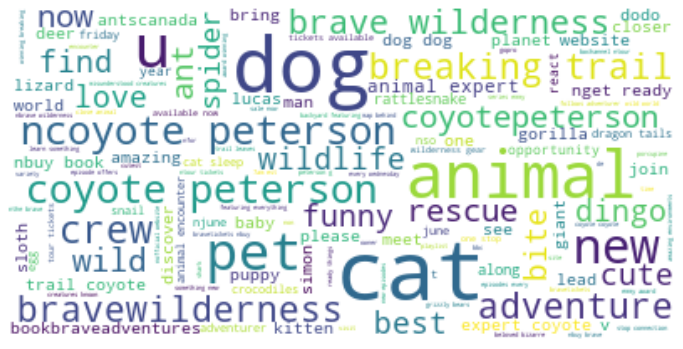


        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
        10 palabras más frecuentes en Education para los 50 videos mas vistos
        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    


'Education'

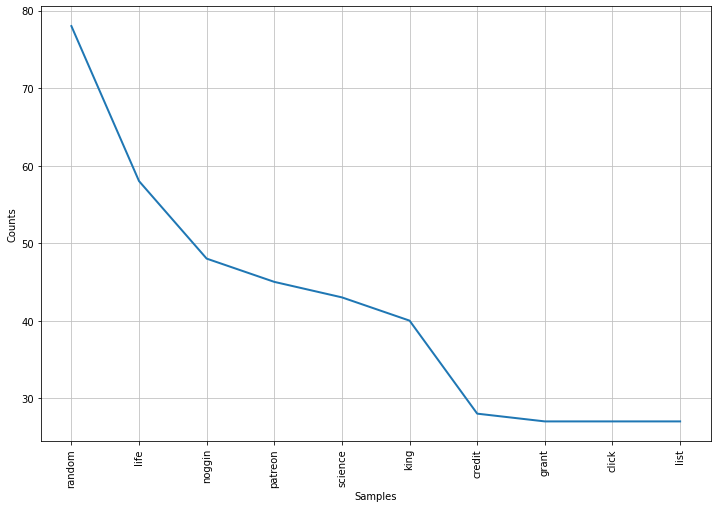

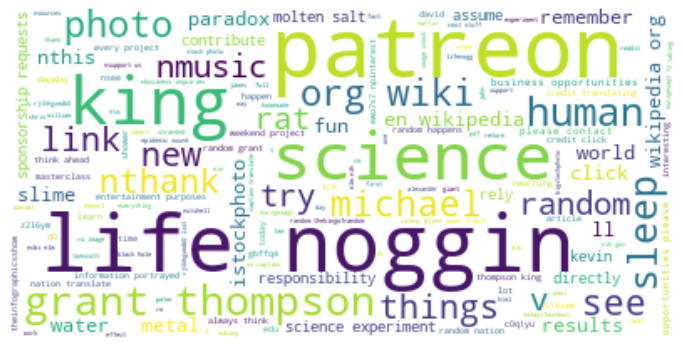


        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
        10 palabras más frecuentes en Howto & Style para los 50 videos mas vistos
        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    


'Howto & Style'

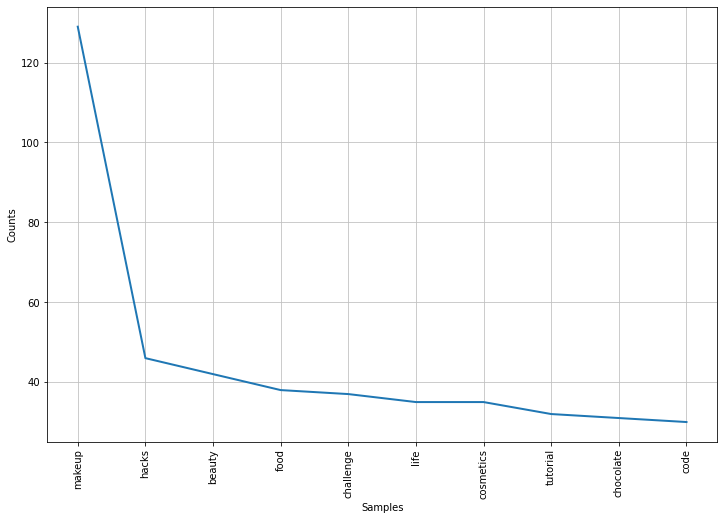

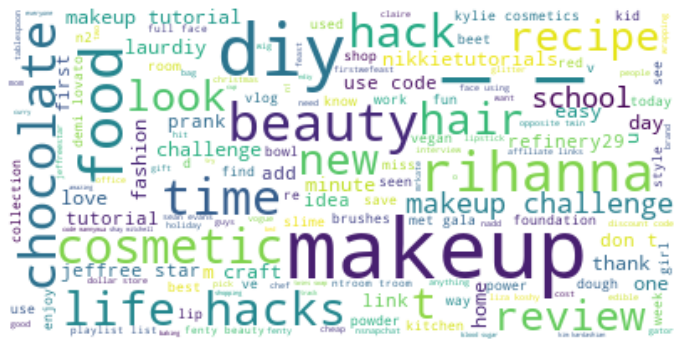


        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
        10 palabras más frecuentes en Autos & Vehicles para los 50 videos mas vistos
        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    


'Autos & Vehicles'

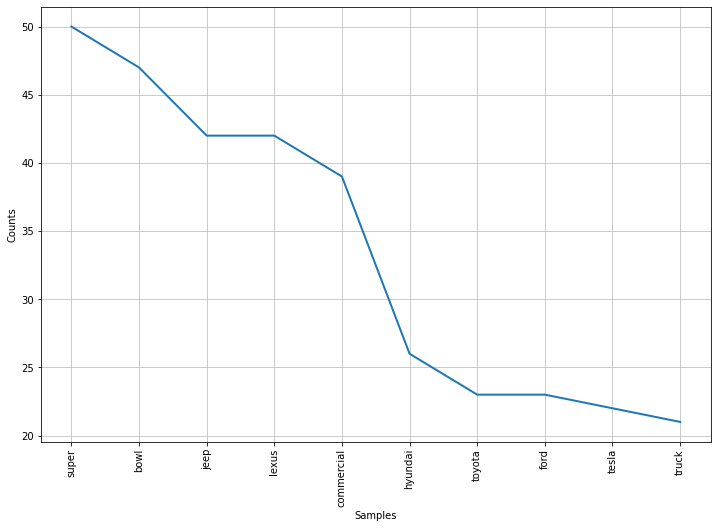

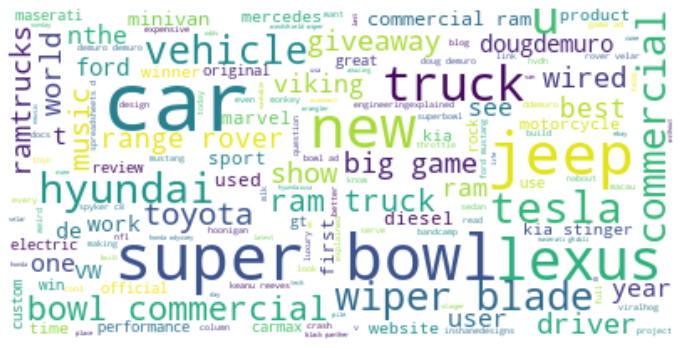


        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
        10 palabras más frecuentes en Travel & Events para los 50 videos mas vistos
        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    


'Travel & Events'

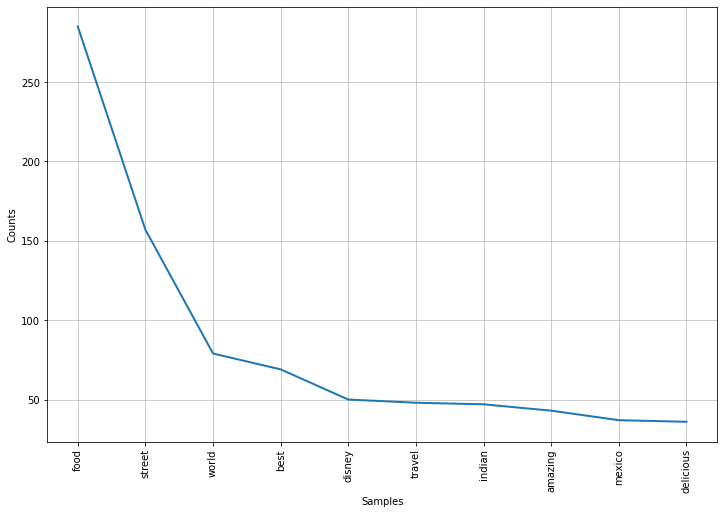

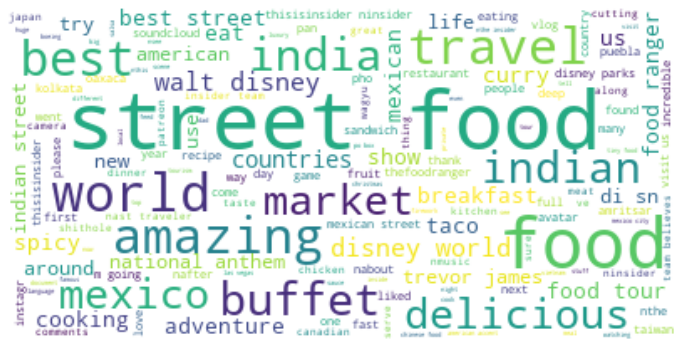


        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
        10 palabras más frecuentes en Gaming para los 50 videos mas vistos
        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    


'Gaming'

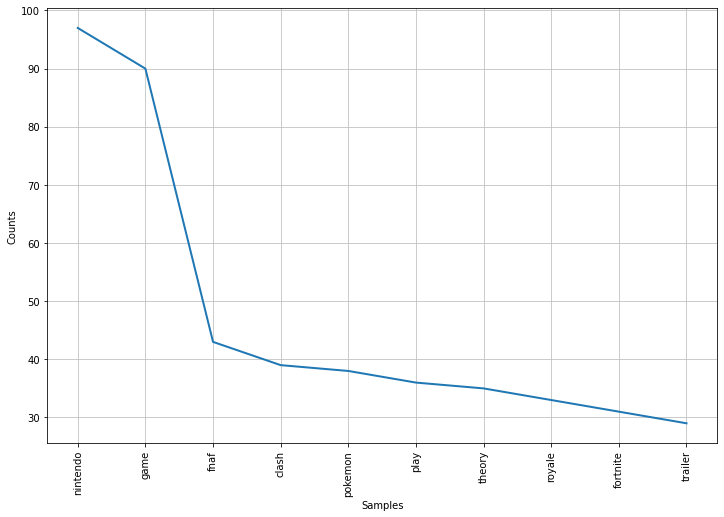

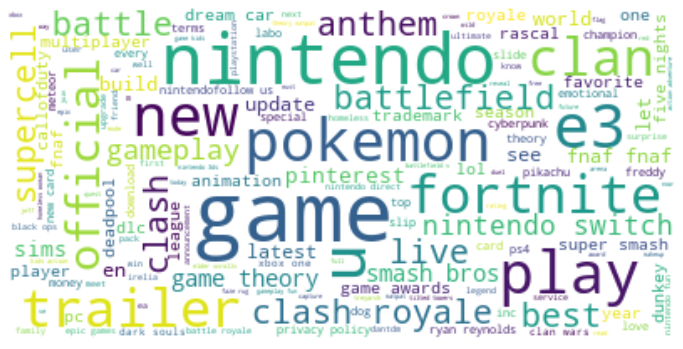


        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
        10 palabras más frecuentes en Nonprofits & Activism para los 50 videos mas vistos
        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    


'Nonprofits & Activism'

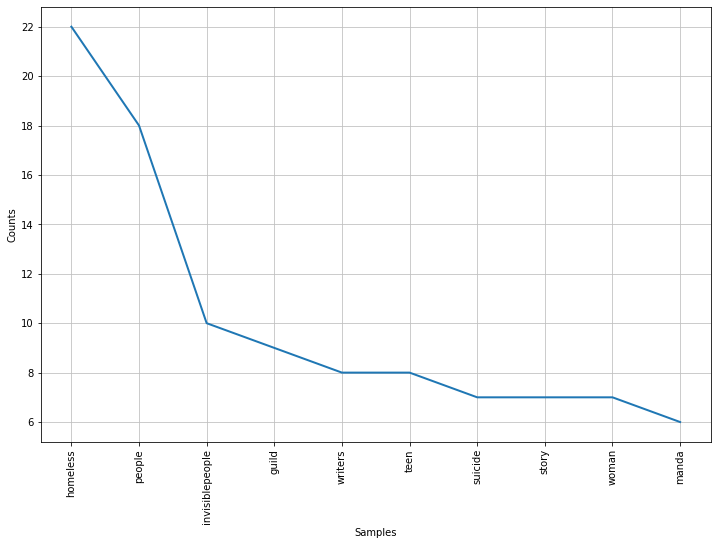

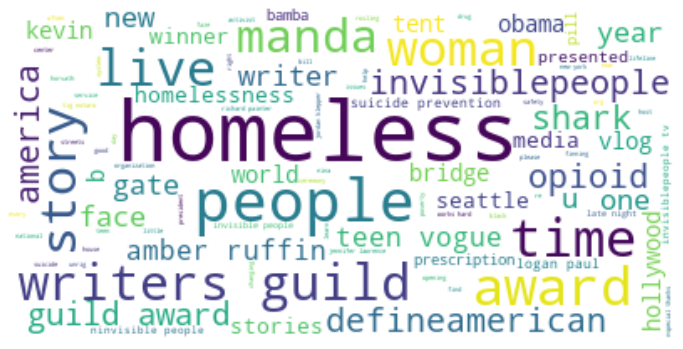


        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
        10 palabras más frecuentes en Shows para los 50 videos mas vistos
        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    


'Shows'

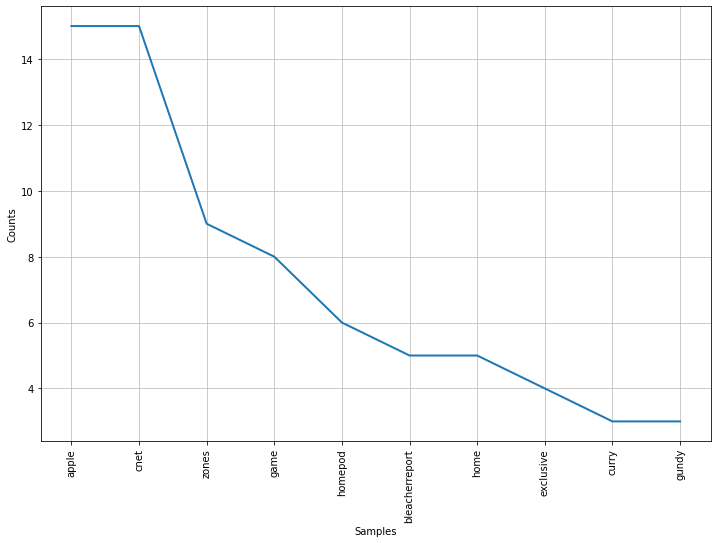

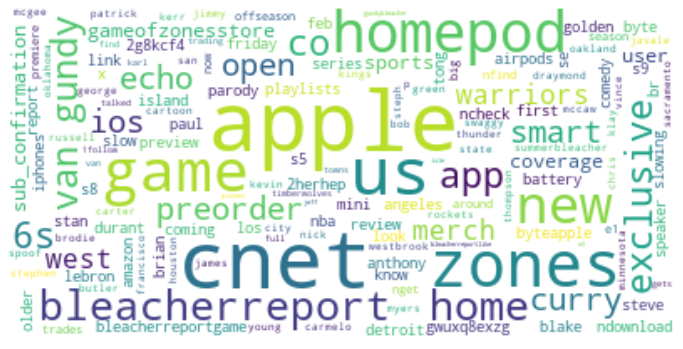

In [72]:
for category in categories:
    df_top_for_category = df[df['category_name'] == category].groupby('video_id', as_index=False)\
        [['description', 'video_title', 'tags', 'views']].max().sort_values(by='views', ascending=False)[:50]
    description = df_top_for_category['description'].values
    video_title = df_top_for_category['video_title'].values
    tags = df_top_for_category['tags'].values

    text = description + video_title + tags
    
    try:
        text = ' '.join(text)
    except Exception:
        text = ' '
    
    tokenlist = nltk.word_tokenize(text, 'english')
    fdist = nltk.FreqDist([word for word in tokenlist if len(word) > 3 if word not in stopwords])
    most_common = fdist.most_common(10)
    print(f"""
        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
        10 palabras más frecuentes en {category} para los 50 videos mas vistos
        ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    """)
    display(category)
    fdist.plot(10)
    generate_wordcloud(text, stopwords)

### 4. ¿La temporada o fecha en el que el video es publicado tiene alguna influencia? 

In [73]:
df_trending = pd.DataFrame()
df_trending['video_id'] = df['video_id']
df_trending['published_date'] = df['publish_time']
df_trending['trending_date'] = df['trending_date']
df_trending['views'] = df['views']

In [74]:
total_day_trending = df_trending.groupby('video_id', as_index=False)['trending_date'].count()
total_day_trending.rename({'trending_date':'total_trending_days'}, axis=1, inplace=True)


In [75]:
df_trending = pd.merge(df_trending, total_day_trending, how='left', on='video_id')


In [76]:
df_trending_max = df_trending.groupby('video_id', as_index=False).max()
df_trending_max['publish_year'] = df_trending_max['published_date'].dt.year
df_trending_max['publish_month'] = df_trending_max['published_date'].dt.month_name()
df_trending_max['publish_day'] = df_trending_max['published_date'].dt.day
df_trending_max.groupby('publish_year')['views'].count()

publish_year
2006       1
2008       3
2009       5
2010       6
2011       8
2012       8
2013      13
2014       7
2015      10
2016       9
2017    2153
2018    4128
Name: views, dtype: int64

In [77]:
def plot_per_month(df, year, month=None):
    df_temp = df[df['publish_year'] == year]
    if month:
        df_temp = df_temp[df['publish_month'] == month]
        fig = px.bar(data_frame=df_temp, 
        x='publish_day' ,y='total_trending_days', title='Trending days per Month in {}/{}'.format(month, year))
        display("La mediana de dias en tendencia en {} es {}".format(month, np.median(df_temp['total_trending_days'])))
        fig.show()
        fig2 = px.bar(data_frame=df_temp, 
        x='publish_day', y='views', title='Views per day in {}/{}'.format(month, year))
        display("La mediana de views en {} es {}".format(month, np.median(df_temp['views'])))
        fig2.show()
        return 'Done!'
    fig = px.bar(df_temp, 'publish_month', 'views', title='Views per Month in {}'.format(year))
    fig.show()
    fig2 = px.bar(df_temp, 'publish_month', 'total_trending_days', title='Total trending days per month in {}'.format(year))
    fig2.show()

In [78]:
plot_per_month(df_trending_max, 2018)

In [79]:
plot_per_month(df_trending_max, 2018, 'May')

'La mediana de dias en tendencia en May es 1.0'

'La mediana de views en May es 1562000.0'

'Done!'

Nota: Se toma en cuenta el año `2018` debido a que corresponde al año con mayor cantidad de registros

### Conclusiones:
* Para el año 2018 `May` fue un año idoneo para publicar videos, ya que en este mes se concentro la mayor cantidad de videos que lograron ser tedencias:
 * Obtuvieron una mediana de 12 dias siendo tendencia
 * Obtuvieron una mediana de 1.5 millones de visualizaciones durante el mes
* En general a excepcion de `June` durante el 2018 todos los videos que conforman el dataset analizado lograron conseguir ser tendencia en por lo menos **2 dias** acumulando mas de **5000 videos** publicados como minimo en los otros meses

### 5. ¿Es posible predecir cuantos likes o visitas tendrá un video? Si es así, crea un modelo que lo compruebe.

In [80]:
print(df.shape)
df.head(1)

(6351, 15)


video_id trending_date  category_id        publish_time  views  likes  \
10  9wRQljFNDW8    2017-11-14           17 2017-11-13 02:05:26  81377    655   

    dislikes  comment_count category_name  \
10        25            177        Sports   

                                                 tags  \
10  nfl football offense defense afc nfc american ...   

                                          video_title channel_title  \
10  dion lewis 103-yd kick return td vs denver can...           nfl   

                                          description trending_month  \
10  new england patriots returner dion lewis blast...       November   

    trending_year  
10           2017

Generaremos un nuevo `DataFrame` que contenga información de valor para alimentar nuestro modelo, algunas columnas que contendrá son:
* total_trending_days
* likes
* category_id
* dislikes
* total_views
* published_minute
* published_hour
* published_day
* published_week
* published_month
* published_year

In [81]:
print(df_trending.shape)
df_trending.head(1)

(6351, 5)


video_id      published_date trending_date  views  total_trending_days
0  9wRQljFNDW8 2017-11-13 02:05:26    2017-11-14  81377                    1

In [82]:
df2 = pd.merge(df, df_trending_max[['video_id', 'total_trending_days']], how='right',
                on='video_id')
df2.shape

(6351, 16)

Comprobamos el resultado del `merge` sobre los dos `DataFrame`

In [83]:
df2[df2['video_id'] == '-0CMnp02rNY']
#df2.head(1)

video_id trending_date  category_id        publish_time   views  likes  \
0  -0CMnp02rNY    2018-06-11           24 2018-06-04 13:00:00  800359   9773   

   dislikes  comment_count  category_name  \
0       332            423  Entertainment   

                                                tags  \
0  ellen ellen degeneres the ellen show ellentube...   

                                         video_title channel_title  \
0  mindy kaling s daughter had the perfect reacti...  theellenshow   

                                         description trending_month  \
0  ocean s 8 star mindy kaling dished on bringing...           June   

   trending_year  total_trending_days  
0           2018                    1

In [84]:
drop_columns_no_numericals = ['video_id', 'tags', 'video_title', 'channel_title',
       'description', 'trending_month']

In [85]:
df2.drop(drop_columns_no_numericals, axis=1, inplace=True)

In [86]:
df2['published_year'] = df2['publish_time'].dt.year
df2['published_month'] = df2['publish_time'].dt.month
df2['published_week'] = df2['publish_time'].dt.week
df2['published_day'] = df2['publish_time'].dt.day
df2['published_hour'] = df2['publish_time'].dt.hour
df2['published_minute'] = df2['publish_time'].dt.minute
df2.head(2)


trending_date  category_id        publish_time   views  likes  dislikes  \
0    2018-06-11           24 2018-06-04 13:00:00  800359   9773       332   
1    2018-02-01           24 2018-01-29 14:00:39  563746   4429        54   

   comment_count  category_name  trending_year  total_trending_days  \
0            423  Entertainment           2018                    1   
1             94  Entertainment           2018                    1   

   published_year  published_month  published_week  published_day  \
0            2018                6              23              4   
1            2018                1               5             29   

   published_hour  published_minute  
0              13                 0  
1              14                 0

Eliminamos las columnas tipo `datetime` que ya fueron desempaquetadas

In [87]:
df2.drop(['trending_date', 'publish_time', 'trending_year'], axis=1, inplace=True)
df2.sample(3)

category_id   views  likes  dislikes  comment_count  category_name  \
5844           17  232142   6604       127            500         Sports   
4113           26  607422  26166       895           3517  Howto & Style   
3773           17  183106   2648        59            244         Sports   

      total_trending_days  published_year  published_month  published_week  \
5844                    1            2017               12              48   
4113                    1            2018                6              24   
3773                    1            2018                2               7   

      published_day  published_hour  published_minute  
5844              2              19                 0  
4113             12              18                55  
3773             17              13                 0

Momento de exportar nuestro nuevo `Dataset` para crear nuestro modelo

In [88]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6351 entries, 0 to 6350
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   category_id          6351 non-null   int64   
 1   views                6351 non-null   int64   
 2   likes                6351 non-null   int64   
 3   dislikes             6351 non-null   int64   
 4   comment_count        6351 non-null   int64   
 5   category_name        6351 non-null   category
 6   total_trending_days  6351 non-null   int64   
 7   published_year       6351 non-null   int64   
 8   published_month      6351 non-null   int64   
 9   published_week       6351 non-null   int64   
 10  published_day        6351 non-null   int64   
 11  published_hour       6351 non-null   int64   
 12  published_minute     6351 non-null   int64   
dtypes: category(1), int64(12)
memory usage: 651.9 KB


In [89]:
df2.to_csv('../data/model_data/youtube_num.csv', index=False)